In [1]:
import sys
import os
import pathlib
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import gdown
import zipfile

# Uncomment if you haven't installed sred
if '../src' not in sys.path:
   sys.path.append('../src')

import sred
# import sred.tools.depth_viewer as dv

2026-02-01 17:15:08.779835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Download Kinect v2 Data

Sample data from the CoRBS Dataset.

<https://ieeexplore.ieee.org/abstract/document/7477636>

    @inproceedings{
        wasenmuller2016corbs,
        author={Wasenmüller, Oliver and Meyer, Marcel and Stricker, Didier},
        booktitle={2016 IEEE Winter Conference on Applications of Computer Vision (WACV)},
        title={CoRBS: Comprehensive RGB-D benchmark for SLAM using Kinect v2},
        year={2016},
        pages={1-7},
        doi={10.1109/WACV.2016.7477636}
    }

In [2]:
data_dir = pathlib.Path('../CoRBS')
os.makedirs(data_dir, exist_ok=True)

data_sequences = [
    ("H1_raw", "1HFLvbGsOcNAKGHU5lQt4nxCBX2tZxLIP"),
    ("H2_raw", "1Q77ONSPmMdzZ1NBGIbrT7N1wVtTT0n24"),
    ("H3_raw", "1daYgyJW1qUW_0LHNKTniIDduWvG8XHJA"),
    # H4_raw used in the original work but here ommitted due to cloud storage limitations
    ("H5_raw", "1NyCFYMgeJ9VUh6MTL1yPBro8wrAP5QNV")
]

In [3]:
# Download and unzip
delete_zip = True
for name, file_id in data_sequences:
    url = f'https://drive.google.com/uc?id={file_id}&confirm=t'
    zip_path = data_dir / (name + '.zip')
    
    if (data_dir / name).is_dir():
        print(f'\nSequence {name} Already Exists, Skipping.')
        continue
    
    gdown.download(url, str(zip_path), quiet=False)
    # python function may sometimes fail with large files
    # retry with shell command
    if not zip_path.is_file():
        print('\nDownloading through shell...')
        print('From:', url)
        print('To:', zip_path)
        !gdown -O {str(zip_path)} {url}
    
    with zipfile.ZipFile(zip_path, 'r') as archive:
        print('Extracting...')
        archive.extractall(data_dir) # folder inside already has name
    if delete_zip:
        print('Deleting zip...')
        os.remove(zip_path)


Sequence H1_raw Already Exists, Skipping.

Sequence H2_raw Already Exists, Skipping.

Sequence H3_raw Already Exists, Skipping.

Sequence H5_raw Already Exists, Skipping.


# Generate Training Targets

In [4]:
d_dirs = [data_dir / name / 'depth' for name, _ in data_sequences]
rgb_dirs = [data_dir / name / 'rgb' for name, _ in data_sequences]
target_dirs = [data_dir / f'{name}_targets' for name, _ in data_sequences]

In [5]:


cam_params = {
    # intrinsics
    'd_fx': 363.58,
    'd_fy': 363.53,
    'd_cx': 250.32,
    'd_cy': 212.55,
    'rgb_fx': 1054.35,
    'rgb_fy': 1054.51 + -15,
    'rgb_cx': 956.12,
    'rgb_cy': 548.99,
    # extrinsics
    'angle': 0,
    't_x': 290,
    't_y': -10 +10
}

target_gen_params = {
    'strat': 'interGFMM',
    'cleaner_min': 5,
    'cam_params': cam_params
}

In [6]:
target_gen = sred.data.TargetGenerator(target_gen_params)
totals = target_gen.generate(d_dirs, rgb_dirs, target_dirs, exist_ok=True)

print('\nNumber of targets per folder:', totals)

Generating to directory ../CoRBS/H1_raw_targets
[Directory Already Exists. Skipping]

Generating to directory ../CoRBS/H2_raw_targets
[Directory Already Exists. Skipping]

Generating to directory ../CoRBS/H3_raw_targets
[Directory Already Exists. Skipping]

Generating to directory ../CoRBS/H5_raw_targets
[Directory Already Exists. Skipping]

[All Done]

Number of targets per folder: [1468, 2547, 1236, 1756]


In [7]:
img_path = img_paths = np.array(sorted(list(target_dirs[0].glob('*.png'))))[0]
print(sred.utils.read_img(img_path).max())

34390


(424, 512)
30350
(424, 512)
39960
(424, 512)
39115
(424, 512)
38305
(424, 512)
36680
(424, 512)
39700
(424, 512)
37940
(424, 512)
36580
(424, 512)
34600


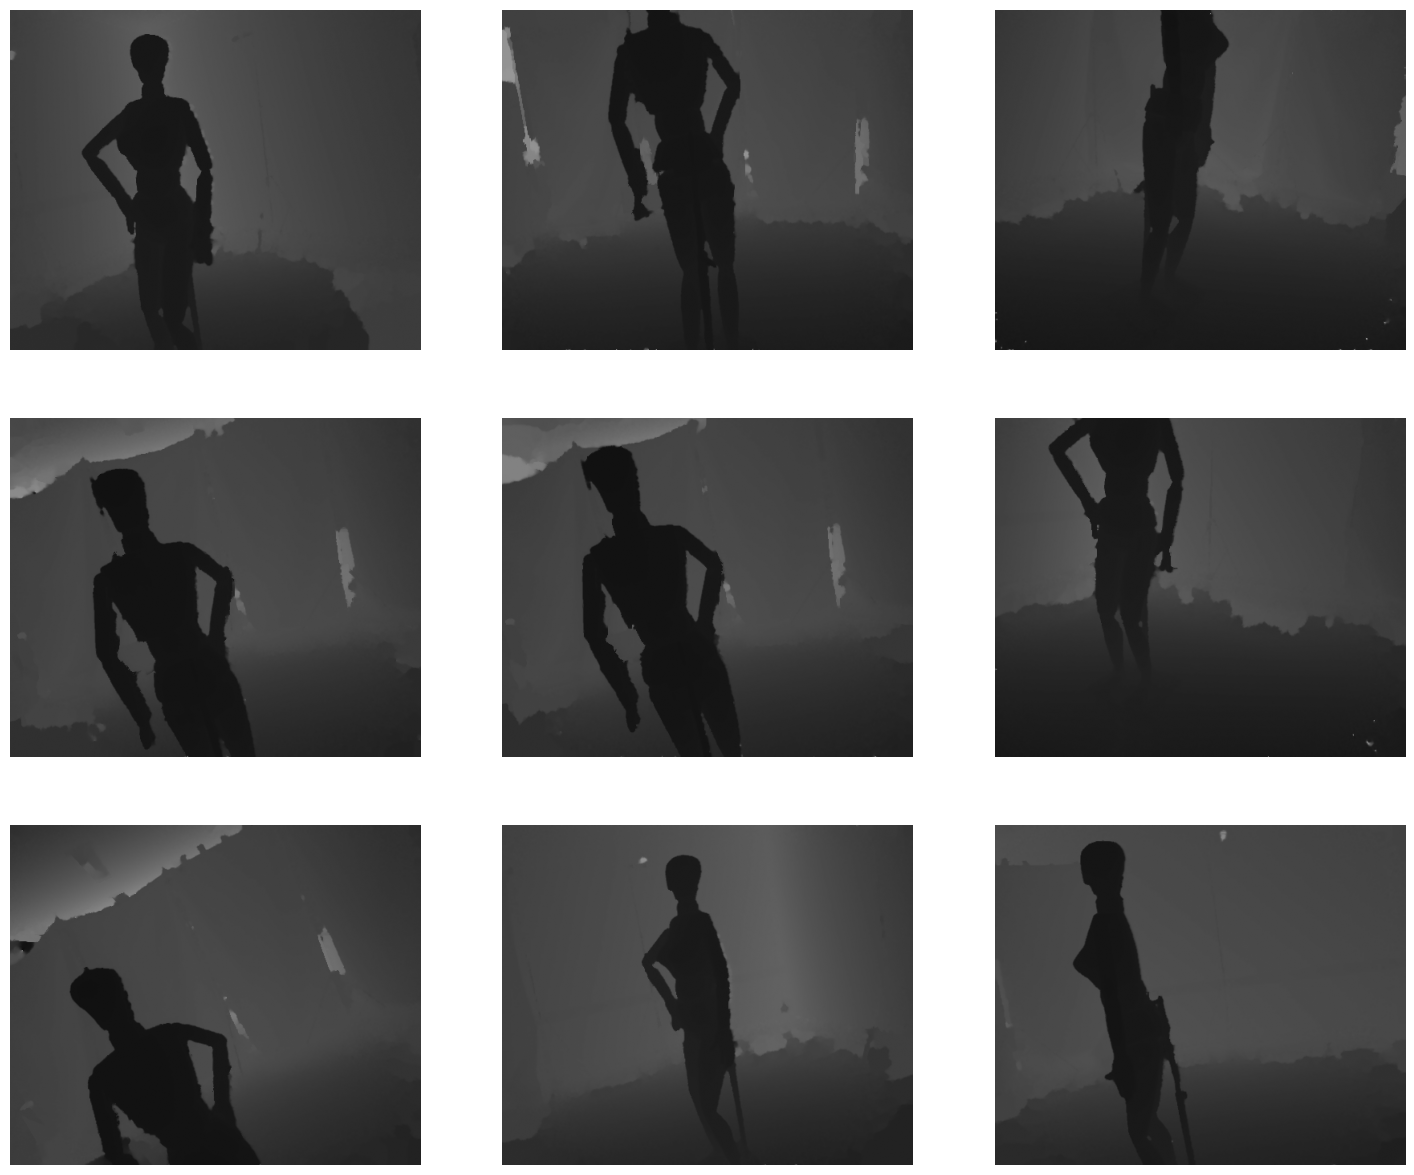

In [8]:
# Preview generated targets

n = 9
cols = 3
rows = n//cols + (n%cols > 1)
img_paths = np.array(sorted(list(target_dirs[0].glob('*.png'))))
np.random.seed(12345)
indices = np.random.randint(len(img_paths), size=n)

plt.figure(figsize=(6*cols, 5*rows))
for i, img_path in enumerate(img_paths[indices]):
    plt.subplot(rows, cols, i + 1)
    img = sred.utils.read_img(img_path)
    print(img.shape)
    print(img.max())
    plt.imshow(img, cmap='gray', vmin=0, vmax=np.iinfo('uint16').max)
    plt.axis('off')

plt.show()

# Build Dataset Objects

In [9]:
batch_size = 16

train_ds, val_ds, test_ds = sred.data.build_all_datasets(
    d_dirs,
    target_dirs,
    batch_size=batch_size,
    val_split = 0.1,
    test_split = 0.04
)

I0000 00:00:1769962514.793226 1304232 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9996 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


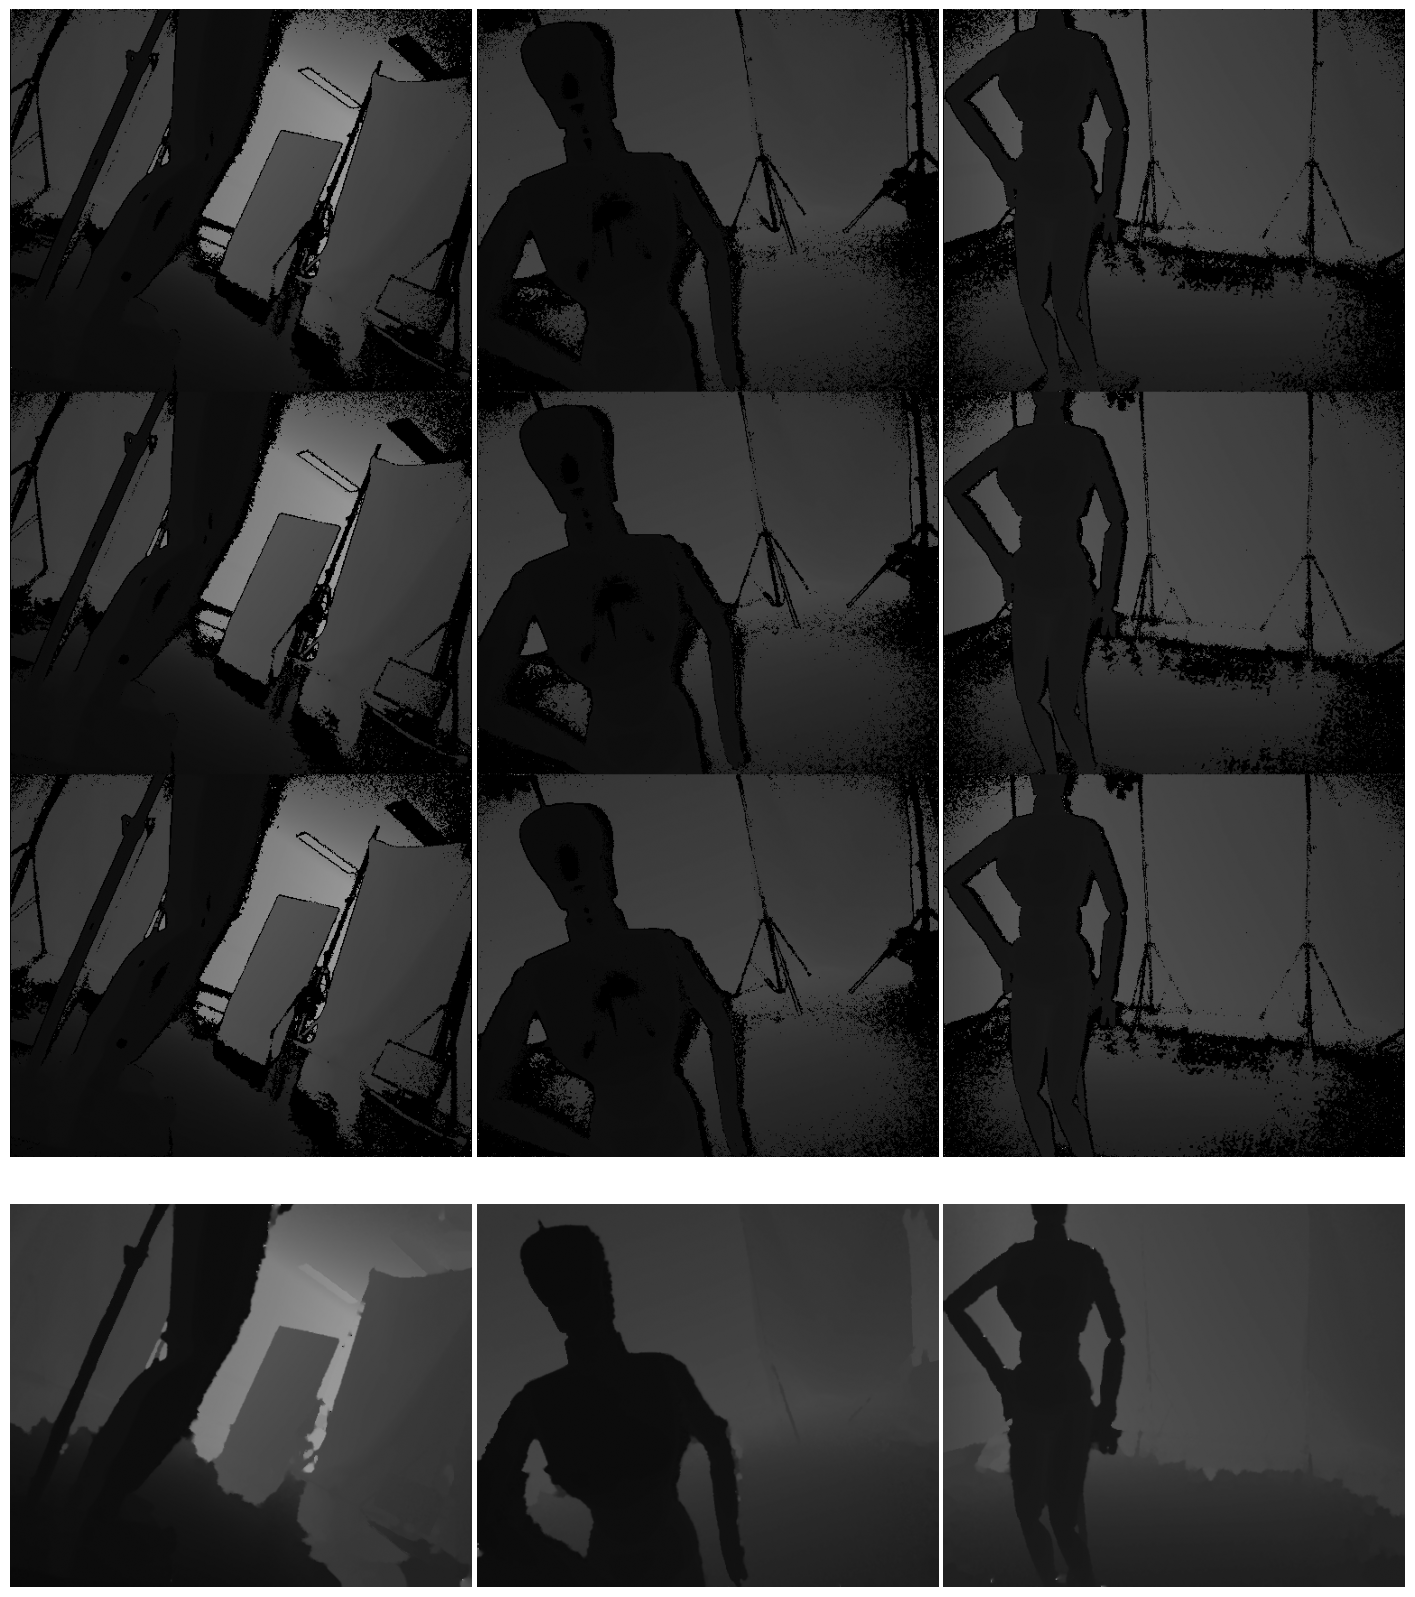

In [10]:
n = 3
fig, ax = plt.subplots(2, n, figsize=(18, 21),
                        gridspec_kw={'height_ratios': [3,1], 'wspace': 0.01, 'hspace': 0.01})

input_batch, target_batch = next(iter(train_ds.take(1)))
for i, (input_img, target_img) in enumerate(zip(input_batch[:n], target_batch[:n])):
    ax[0, i].imshow(tf.concat([input_img[:,:,i] for i in range(input_img.shape[-1])], axis=0), cmap='gray', vmin=0, vmax=1)
    ax[0, i].set_axis_off()
    ax[1, i].imshow(target_img, cmap='gray', vmin=0, vmax=1)
    ax[1, i].set_axis_off()

plt.show()

# Define Model

In [11]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda --xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found'

# Now you can import tensorflow
import tensorflow as tf

In [12]:
in_sample, tg_sample = next(iter(train_ds.take(1)))
frame_shape = tuple(tg_sample.shape[1:])
input_frames = in_sample.shape[-1] // frame_shape[-1]

In [13]:
print(input_frames)
print(frame_shape)

3
(424, 512, 1)


In [14]:
# Find data shapes
in_sample, tg_sample = next(iter(train_ds.take(1)))
frame_shape = tuple(tg_sample.shape[1:])
input_frames = in_sample.shape[-1] // frame_shape[-1]

# Create Model
model = sred.SReDModel(frame_shape, input_frames, residual=-1)
model.default_compile()
model.summary()

# Prepare output directory
output_dir = pathlib.Path('out')
os.makedirs(output_dir, exist_ok=True)

# Save initial weights with correct TensorFlow format
initial_weights_path = output_dir / "initial_model.weights.h5"
model.save_weights(initial_weights_path)

/home/hs2025_mkrahforst/ST/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'up_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "s_re_d_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_block (FirstBlock)        │ (None, 424, 512, 32)   │        10,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block (DownBlock)          │ (None, 212, 256, 32)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_1 (DownBlock)        │ (None, 106, 128, 48)   │        34,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_2 (DownBlock)        │ (None, 53, 64, 48)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_3 (DownBlock)        │ (None, 27, 32, 64)     │        64,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_4 (DownBlock)        │ (None, 14, 16, 128)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block (UpBlock)              │ (None, 27, 32, 128)    │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_1 (UpBlock)            │ (None, 53, 64, 64)     │       184,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_2 (UpBlock)            │ (None, 106, 128, 48)   │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_3 (UpBlock)            │ (None, 212, 256, 48)   │        83,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_4 (UpBlock)            │ (None, 424, 512, 32)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_block (LastBlock)          │ (None, 424, 512, 1)    │        28,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,260,865 (4.81 MB)

 Trainable params: 1,260,865 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [15]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
print(initial_weights_path)

out/initial_model.weights.h5


In [17]:
epochs = 200
steps_per_epoch = 200

model.load_weights(initial_weights_path)

res = model.default_fit(
    train_ds,
    epochs,
    steps_per_epoch,
    validation_data = val_ds,
    output_dir = output_dir
)

print(f"\nTotal time:",
    f"{res['time']/3600:.0f}h" +
    f"{res['time']%3600/60:.0f}m" +
    f"{res['time']%3600%60:.2f}")

if res['best_checkpoint_path'] is not None:
    print('\nSaved to:', res['best_checkpoint_path'].parent)

Epoch 1/200


2026-02-01 17:15:24.190605: I external/local_xla/xla/service/service.cc:163] XLA service 0x742b38003ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-01 17:15:24.190625: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2026-02-01 17:15:24.349839: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-01 17:15:25.066622: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


  1/200 ━━━━━━━━━━━━━━━━━━━━ 1:18:24 24s/step - loss: 0.0381

I0000 00:00:1769962544.015214 1304489 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.0082 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.0064 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.0057 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.0054 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.0054 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.0050 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 0.0047 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 9/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.0048 - val_loss: 0.0051 - learning

In [18]:
import tensorflow as tf
print(tf.config.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


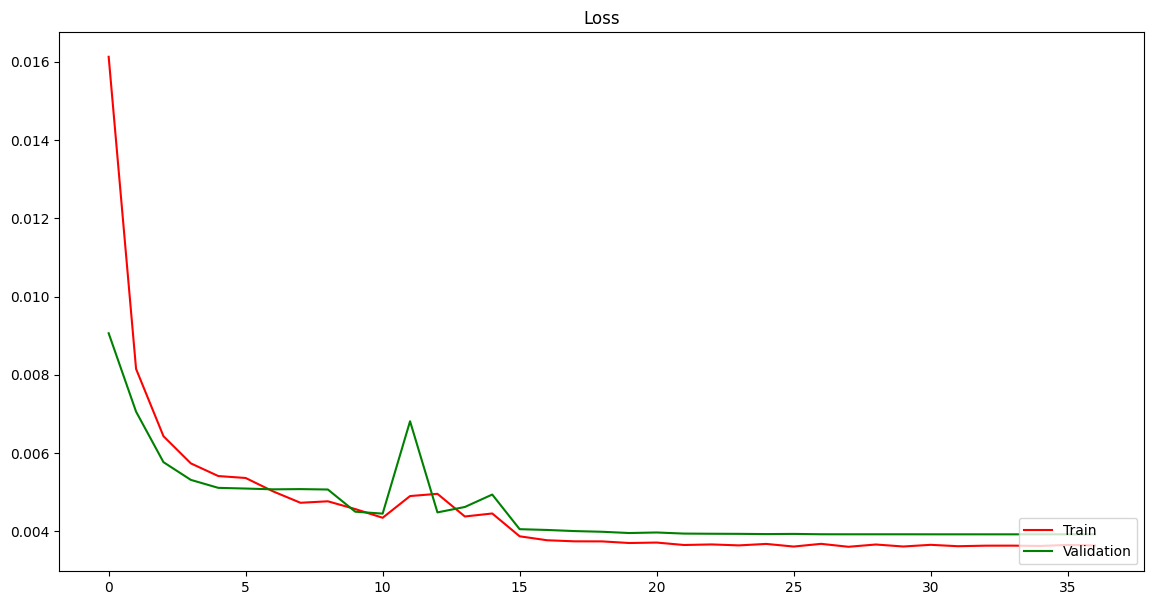

In [19]:
plt.figure(figsize=(14,7))
plt.title('Loss')
plt.plot(res['history'].history['loss'], '-r', label='Train')
plt.plot(res['history'].history['val_loss'], '-g', label='Validation')
plt.legend(loc=4)
plt.show()

# Test

In [20]:
# Test prediction one image at a time

model.load_weights(res['best_checkpoint_path'])

store_size = 20
predictions = []
start_time = time.time()
test_size = 0
for tensor_in in test_ds:
    pred = model.predict(tensor_in)
    test_size += 1
    if len(predictions) < store_size:
        predictions += [pred]
avg_test_time = (time.time() - start_time) / test_size

print(f'Predictions Done [{test_size}]')
print('Prediction shape:', predictions[0].shape)
print(f'Avg time-per-pred: {avg_test_time*1000:.1f}ms')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

2026-02-01 18:00:42.341061: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
# Test prediction whole test dataset at once

model.load_weights(res['best_checkpoint_path'])

start_time = time.time()
model.predict(test_ds)
avg_test_time = (time.time() - start_time) / test_size

print(f'Avg time-per-pred: {avg_test_time*1000:.1f}ms')

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Avg time-per-pred: 4.7ms


2026-02-01 18:00:43.898019: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


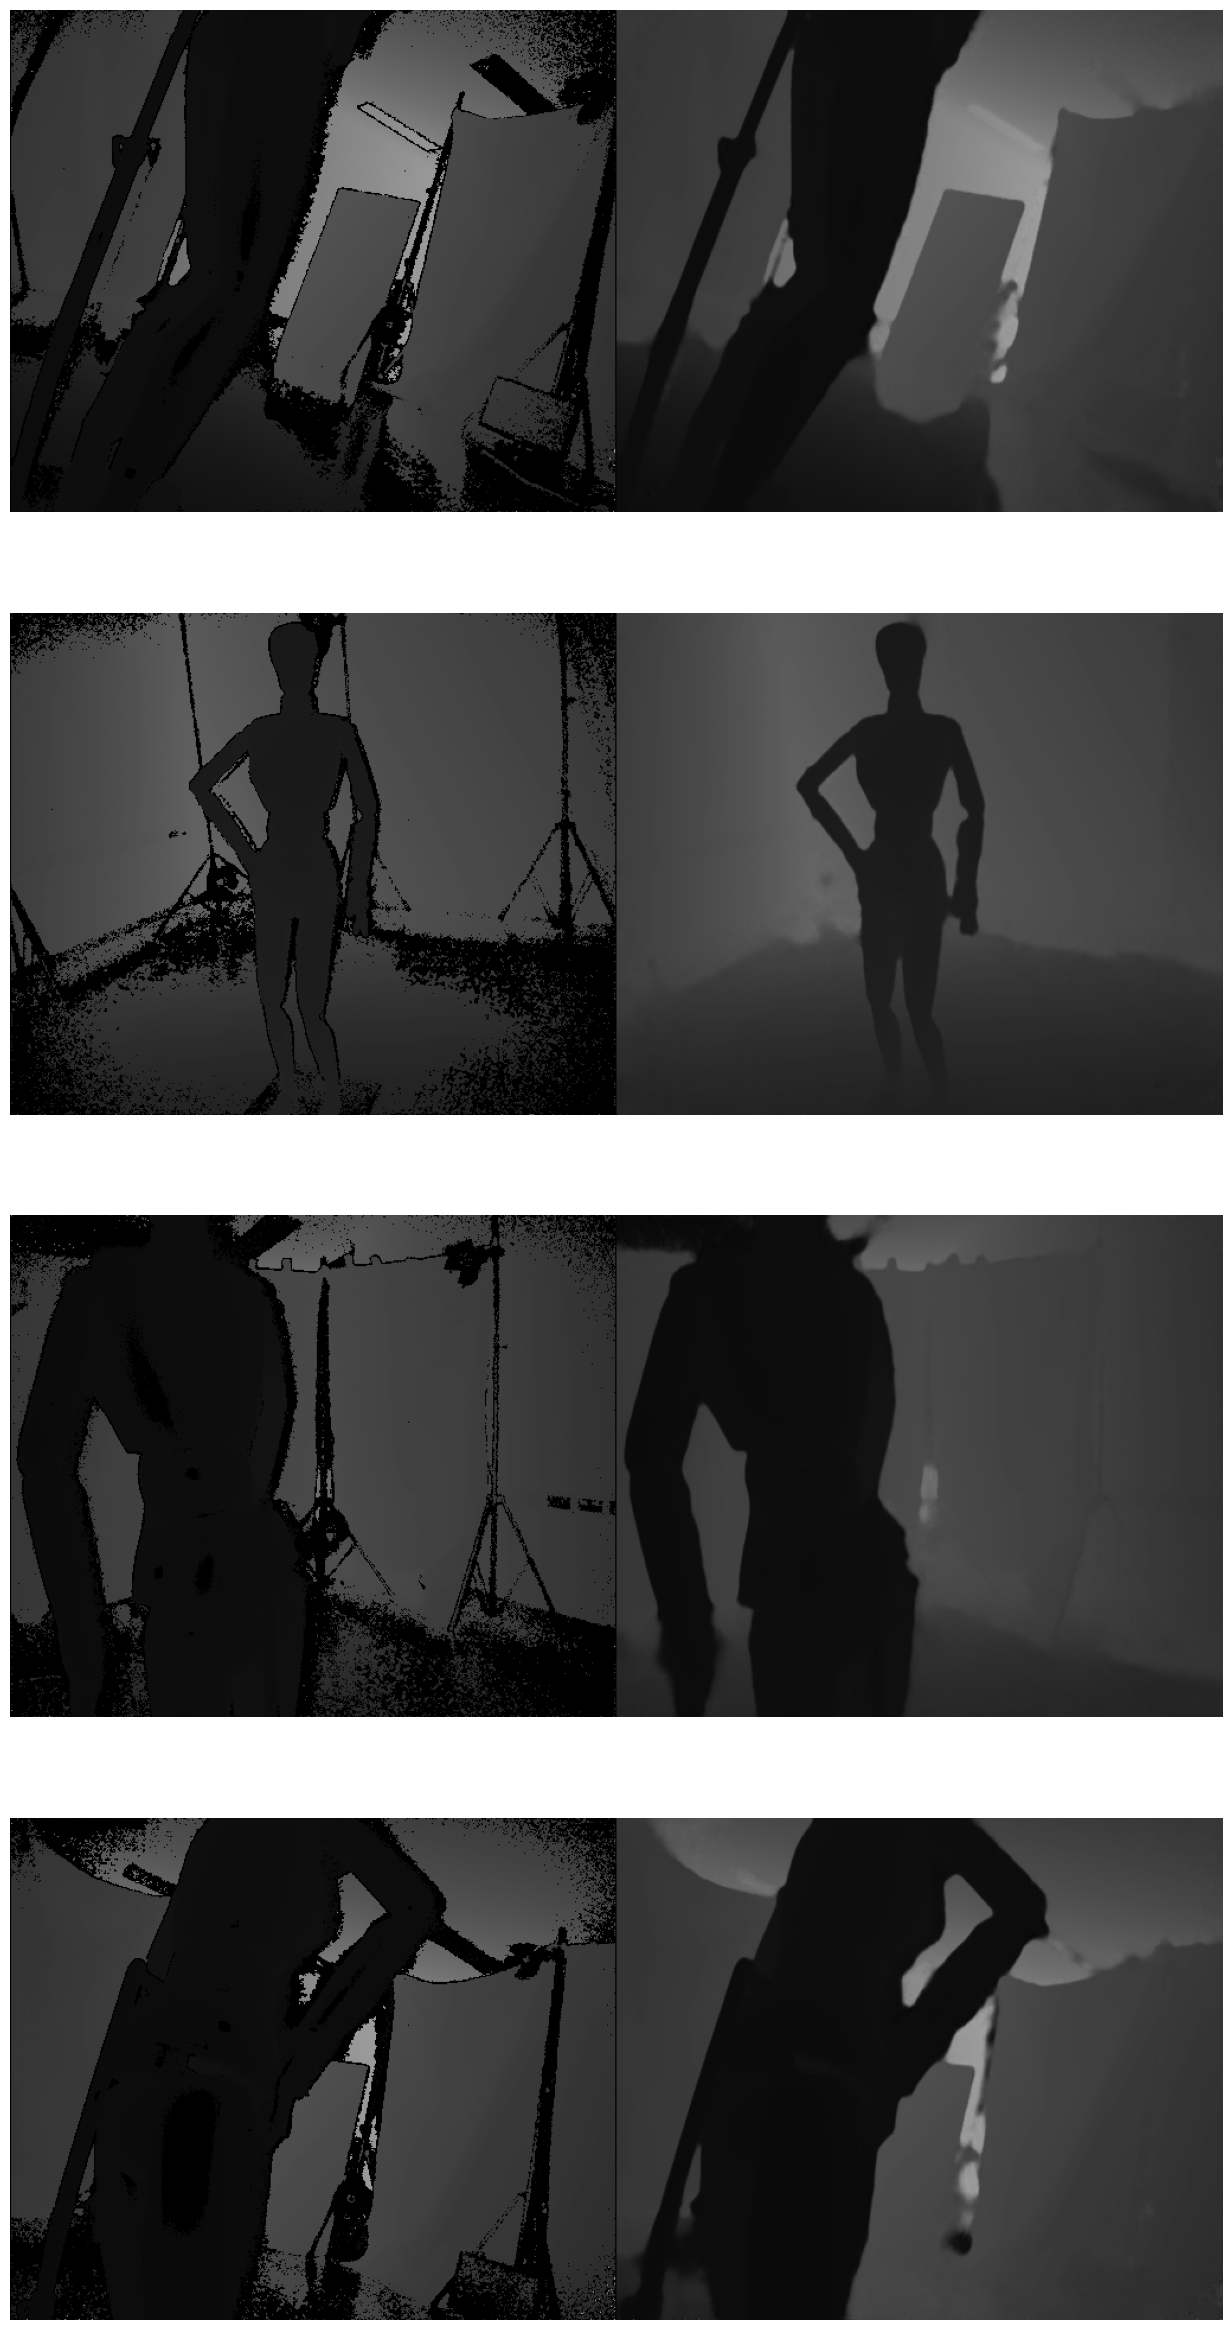

In [22]:
n = 4
skip = 4
plt.figure(figsize=(20, 30))
for i, (tensor_in, np_pred) in enumerate(zip(test_ds.skip(skip).take(n), predictions[skip:skip+n])):
    merged = np.concatenate((tensor_in.numpy()[0,...,-1:], np_pred[0,...]), axis=1)
    plt.subplot(4, 1, i + 1)
    plt.imshow(merged, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.savefig("rawvspred.png", dpi=300) 
plt.show()


# Evaluate

In [25]:
model.load_weights(res['best_checkpoint_path'])

verbose = False

n = 0
vals = []
for tensor_in in test_ds:
    pred = model.predict(tensor_in)
    n += 1
    val = sred.utils.nmid(
        sred.utils.denormalize_frame(tensor_in[0,...,-1]),
        sred.utils.denormalize_frame(pred))
    if verbose: print(val)
    if not np.isnan(val):
        vals += [val]

val_mean = float(np.mean(vals))

if res['best_checkpoint_path'] is not None:
    metric_path = res['best_checkpoint_path'].parent / 'nmid.json'
    with open(metric_path, 'w') as f:
        json.dump({'all': vals, 'mean': val_mean}, f)

print("Avg NMID:", val_mean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [26]:
# Build dataset of sequential frames for temporal evaluation

test_ds_seq = sred.data.build_test_dataset(
    [data_dir / 'H3_raw/depth'],
    items=(-2,-1,0),
    deep_shuffle=False
)

In [27]:
model.load_weights(res['best_checkpoint_path'])

temp_means = []
temp_vars = []
prev = None
for tensor_in in test_ds_seq:
    if prev is None:
        prev = sred.utils.denormalize_frame(model.predict(tensor_in))
        continue
    curr = sred.utils.denormalize_frame(model.predict(tensor_in))
    mean, var = sred.utils.temporal_diff(prev, curr)
    temp_means += [mean]
    temp_vars += [var]
    prev = curr

temp_means_mean = float(np.mean(temp_means))
temp_vars_mean = float(np.mean(temp_vars))

if res['best_checkpoint_path'] is not None:
    metric_path = res['best_checkpoint_path'].parent / 'temporal_diff.json'
    with open(metric_path, 'w') as f:
        json.dump({
            'all_means': temp_means,
            'all_vars': temp_vars,
            'mean_of_means': temp_means_mean,
            'mean_of_vars': temp_vars_mean
        }, f)

print("Avg Temporal Mean:", temp_means_mean)
print("Avg Temporal Variance:", temp_vars_mean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

2026-02-01 18:02:43.231682: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Predict Single

In [28]:
model = sred.SReDModel((424,512, 1), 3, residual=-1)
model.default_compile()
model.summary()
# model.load_weights("out/SReD_training_2025-11-07-21-55-24/cp-weights-best.weights.h5")
model.load_weights(res['best_checkpoint_path'])


/home/hs2025_mkrahforst/ST/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'up_block_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "s_re_d_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_block_1 (FirstBlock)      │ (None, 424, 512, 32)   │        10,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_5 (DownBlock)        │ (None, 212, 256, 32)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_6 (DownBlock)        │ (None, 106, 128, 48)   │        34,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_7 (DownBlock)        │ (None, 53, 64, 48)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_8 (DownBlock)        │ (None, 27, 32, 64)     │        64,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ down_block_9 (DownBlock)        │ (None, 14, 16, 128)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_5 (UpBlock)            │ (None, 27, 32, 128)    │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_6 (UpBlock)            │ (None, 53, 64, 64)     │       184,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_7 (UpBlock)            │ (None, 106, 128, 48)   │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_8 (UpBlock)            │ (None, 212, 256, 48)   │        83,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_block_9 (UpBlock)            │ (None, 424, 512, 32)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_block_1 (LastBlock)        │ (None, 424, 512, 1)    │        28,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,260,865 (4.81 MB)

 Trainable params: 1,260,865 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

/home/hs2025_mkrahforst/ST/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 122 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda --xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found'
os.environ['TF_XLA_FLAGS'] = '--xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found'
# Now you can import tensorflow
import tensorflow as tf

In [60]:
img_paths = [
    "ToF1/depth_00276.png",
    "ToF1/depth_00275.png",
    "ToF1/depth_00274.png"
]


In [55]:
img_paths = [
    "ToF2/depth_00276.png",
    "ToF2/depth_00275.png",
    "ToF2/depth_00274.png"
]


In [47]:
img_paths = [
    "Realsense/depth_00000.png",
    "Realsense/depth_00001.png",
    "Realsense/depth_00002.png"
]


In [61]:
from PIL import Image

target_size = (512, 424)  # (width, height) after crop

one = False
images = []
for path in img_paths:
    # Open image
    img = Image.open(path)

    # Convert to grayscale (1 channel)
    img = img.convert('L')

    # Original size
    orig_w, orig_h = img.size
    crop_w, crop_h = target_size

    # Compute scaling factor to cover target size
    if(one):
        scale = max(crop_w / orig_w, crop_h / orig_h)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
    else:
        new_h = crop_h
        new_w = crop_w

    # Resize while keeping aspect ratio
    img = img.resize((new_w, new_h),  Image.Resampling.LANCZOS)

    # Center crop to target size
    left = (new_w - crop_w) // 2
    top = (new_h - crop_h) // 2
    right = left + crop_w
    bottom = top + crop_h
    img = img.crop((left, top, right, bottom))

    # Convert to NumPy array
    img_array = np.array(img, dtype=np.float32)

    # Optional: normalize
    img_array /= 255.0

    images.append(img_array)

In [37]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np


# Paths to your 3 images
img_paths = [
    "../CoRBS/H1_raw/depth/1437750676.927064.png",
    "../CoRBS/H1_raw/depth/1437750676.894066.png",
    "../CoRBS/H1_raw/depth/1437750676.861147.png"
]


images = []
for path in img_paths:
    img = Image.open(path)  # H, W must match your model
    img_array = np.array(img, dtype=np.float32)
    print(img_array.shape)
    img_array = img_array / np.max(img_array)  # normalize if needed
    images.append(img_array)




(424, 512)
(424, 512)
(424, 512)


In [62]:
# Stack along the channel axis -> shape (H, W, 3)
input_array = np.stack(images, axis=-1)

# Add batch dimension -> shape (1, H, W, 3)
input_array = np.expand_dims(input_array, axis=0)

# Predict
pred = model.predict(input_array)
print(pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(1, 424, 512, 1)


In [39]:
def show_side_by_side(img1, img2, titles=('Noisy', 'Denoised'), save_path=None):
    plt.figure(figsize=(10, 5))

    # First image
    plt.subplot(1, 2, 1)
    if img1.ndim == 2:
        plt.imshow(img1, cmap='gray')
    else:
        plt.imshow(img1.astype(np.uint8))
    plt.title(titles[0])
    plt.axis('off')

    # Second image
    plt.subplot(1, 2, 2)
    if img2.ndim == 2:
        plt.imshow(img2, cmap='gray')
    else:
        plt.imshow(img2.astype(np.uint8))
    plt.title(titles[1])
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

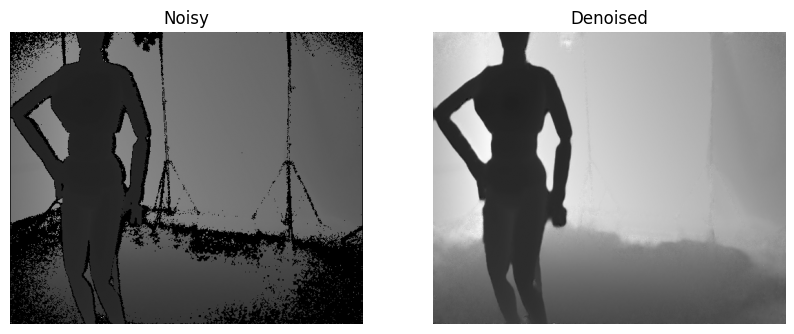

In [ ]:
show_side_by_side(images[-1].squeeze(), pred.squeeze(), save_path="CoRBS.png")

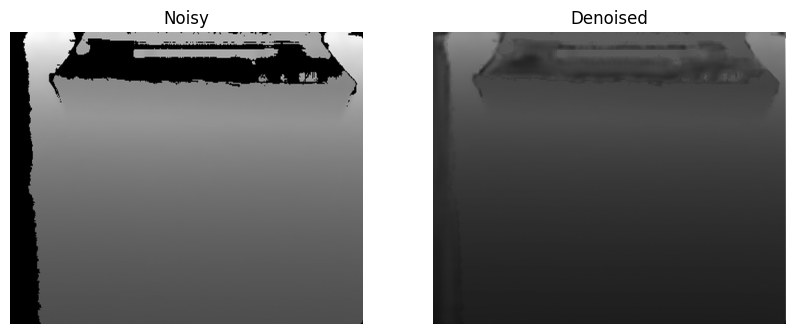

In [50]:
show_side_by_side(images[-1].squeeze(), pred.squeeze(), save_path="Realsense.png")

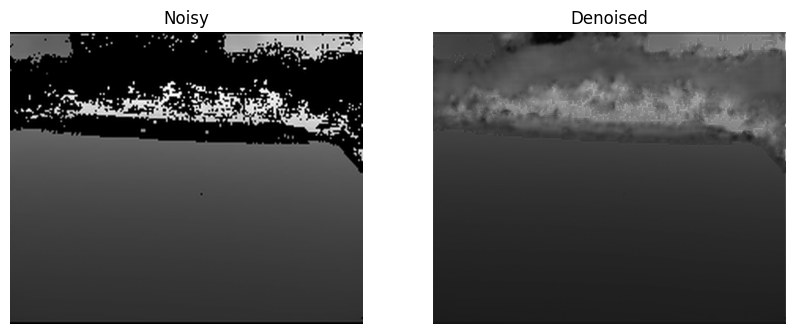

In [63]:
show_side_by_side(images[-1].squeeze(), pred.squeeze(), save_path="ToF1.png")

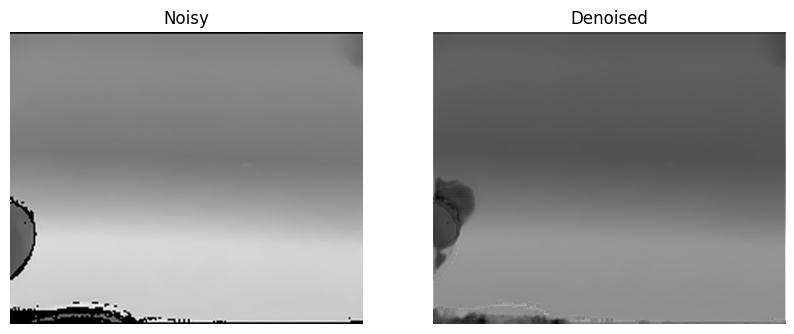

In [59]:
show_side_by_side(images[-1].squeeze(), pred.squeeze(), save_path="ToF2.png")

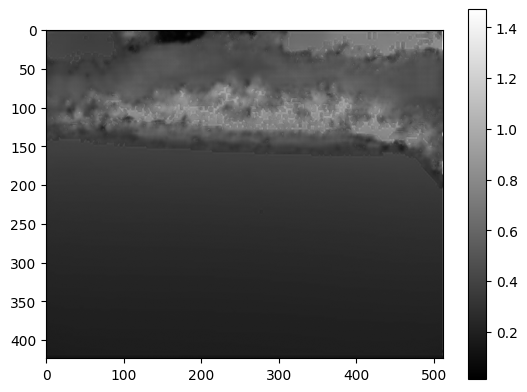

In [66]:
import matplotlib.pyplot as plt

# Remove batch dimension
pred_image = pred  

plt.imshow(pred_image.squeeze(), cmap='gray')  # use 'gray' for single-channel
plt.colorbar()
plt.show()